# Deep Reinforcement Learning for Portfolio Optimization


This experiment demonstrates the application of Deep Reinforcement Learning (DRL) algorithms (`A2C`, `PPO`, `SAC`) for portfolio optimization.  
The workflow includes:

- Fetching and preprocessing Dow 30 market data using FinRL’s `YahooDownloader` and `FeatureEngineer`.
- Splitting the data into training (2010–2024) and trading (2024–2024) datasets.
- Defining a Gym environment (`StockPortfolioEnv`) for portfolio allocation.
- Training three DRL agents (`A2C`, `PPO`, `SAC`) for 50k timesteps each.
- Backtesting each agent’s daily returns and computing performance statistics.
- Constructing a minimum-variance portfolio with `PyPortfolioOpt` and simulating its evolution.
- Retrieving DJIA benchmark returns for comparison.
- Plotting cumulative returns of all strategies side by side.
- Outputting detailed performance metrics for each approach.


## Dependencies


In [6]:
# ! pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# ! conda install -n portfolio_opt ipykernel --update-deps --force-reinstall
# ! pip install pandas_market_calendars quantstats gymnasium -q

In [7]:
! pip install pandas numpy matplotlib \
               stable-baselines3 \
               PyPortfolioOpt \
               pandas_market_calendars quantstats gymnasium \
               git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [8]:
# Standard library imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Stable Baselines3 imports
from stable_baselines3 import A2C, PPO, SAC

# FinRL imports
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

# PyPortfolioOpt imports
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

%matplotlib inline

# Load data


In [ ]:
ticker_list = config_tickers.DOW_30_TICKER
start_date = "2005-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")

display(
    f"Downloading data from {start_date} to {end_date}".format(start_date, end_date)
)
display(f"Tickers: {ticker_list}")

df = YahooDownloader(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list
).fetch_data()

'Downloading data from 2005-01-01 to 2025-04-23'

"Tickers: ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (148857, 8)


## Preprocess data and append technical indicators


In [10]:
print("Preprocessing data...")
fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=False)
df_tech = fe.preprocess_data(df)

df_tech.shape

Preprocessing data...
Successfully added technical indicators


(143024, 16)

# Compute covariance matrices and lists for state representation


In [ ]:
print("Computing covariance matrices...")

df_sorted = df_tech.sort_values(["date", "tic"], ignore_index=True)
df_sorted.index = df_sorted.date.factorize()[0]
cov_list, return_list = [], []
lookback = 252
unique_dates = df_sorted.date.unique()

for i in range(lookback, len(unique_dates)):
    window = df_sorted.loc[i - lookback : i, :]
    price_mat = window.pivot_table(index="date", columns="tic", values="close")
    ret_mat = price_mat.pct_change().dropna()
    return_list.append(ret_mat)
    cov_list.append(ret_mat.cov().values)

# Merge back covariances
df_cov = pd.DataFrame(
    {"date": unique_dates[lookback:], "cov_list": cov_list, "return_list": return_list}
)
df_merged = pd.merge(df_tech, df_cov, on="date", how="left")

# Drop initial rows without cov_list
df_final = df_merged[df_merged["cov_list"].notna()].reset_index(drop=True)

display(f"Final data shape: {df_final.shape}")
display(f"Final data columns: {df_final.columns}")

Computing covariance matrices...


(135968, 18)

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'cov_list', 'return_list'],
      dtype='object')

## Train/Test split


In [ ]:
# train_start, train_end = '2021-01-01', '2024-01-01'
train_start, train_end = "2010-01-01", "2024-01-01"
trade_start, trade_end = "2024-01-01", end_date

train_data = data_split(df_final, train_start, train_end)
trade_data = data_split(df_final, trade_start, trade_end)

## Environment setup


In [13]:
stock_dim = len(train_data.tic.unique())
state_space = stock_dim
tech_indicators = config.INDICATORS
env_kwargs = {
    "stock_dim": stock_dim,
    "hmax": 100,
    "initial_amount": 1e6,
    "transaction_cost_pct": 0.001,
    "reward_scaling": 1e-4,
    "state_space": state_space,
    "action_space": stock_dim,
    "tech_indicator_list": tech_indicators,
}
print(
    f"Stock Dim: {stock_dim}, State Space: {state_space}, Indicators: {tech_indicators}"
)

# Create Gym environments
e_train = StockPortfolioEnv(df=train_data, **env_kwargs)
env_train, _ = e_train.get_sb_env()
e_trade = StockPortfolioEnv(df=trade_data, **env_kwargs)

Stock Dim: 28, State Space: 28, Indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


## Train DRL agents


In [ ]:
results_dir = "results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir, exist_ok=True)

algos = ["a2c", "ppo", "sac"]
trained_models = {}
for algo in algos:
    print(f"Training {algo.upper()}...")
    agent = DRLAgent(env=env_train)
    model = agent.get_model(algo)
    trained = agent.train_model(model=model, tb_log_name=algo, total_timesteps=50000)
    trained_models[algo] = trained

Training A2C...
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 639       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -39.4     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 1.43e+08  |
|    reward             | 1266906.1 |
|    std                | 0.99      |
|    value_loss         | 1.59e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 671       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -39.4    

Save trained models


In [15]:
# Create directory for models if it doesn't exist
models_dir = "results/models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save trained models
for algo, model in trained_models.items():
    model.save(f"results/models/{algo}_trained_model")
    print(f"Model {algo} saved to results/models/{algo}_trained_model")

Model a2c saved to results/models/a2c_trained_model
Model ppo saved to results/models/ppo_trained_model
Model sac saved to results/models/sac_trained_model


Load saved models


In [ ]:
if "trained_models" not in locals() or not trained_models:
    # Check if model files exist before loading
    model_paths = {
        "a2c": "results/models/a2c_trained_model.zip",
        "ppo": "results/models/ppo_trained_model.zip",
        "sac": "results/models/sac_trained_model.zip",
    }

    if all(os.path.exists(path) for path in model_paths.values()):
        trained_models = {
            "a2c": A2C.load(model_paths["a2c"]),
            "ppo": PPO.load(model_paths["ppo"]),
            "sac": SAC.load(model_paths["sac"]),
        }
        print("Models loaded successfully.")
    else:
        print(
            "One or more model files are missing. Please ensure all models are saved correctly."
        )
else:
    print("Trained models are already set up.")

Trained models are already set up.


## Backtest DRL strategies


In [ ]:
results = {}
for algo, model in trained_models.items():
    print(f"Backtesting {algo.upper()}...")
    df_ret, _ = DRLAgent.DRL_prediction(model=model, environment=e_trade)
    # Reconstruct cumulative account value from daily returns
    df_ret["account_value"] = (df_ret["daily_return"] + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats = backtest_stats(df_ret, value_col_name="account_value")
    results[algo] = {"df": df_ret, "stats": stats}

Backtesting A2C...
begin_total_asset:1000000.0
end_total_asset:1075036.4756674282
Sharpe:  0.462503508407117
hit end!
Annual return          0.057343
Cumulative returns     0.075036
Annual volatility      0.142587
Sharpe ratio           0.463211
Calmar ratio           0.420820
Stability              0.715331
Max drawdown          -0.136266
Omega ratio            1.091920
Sortino ratio          0.661962
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.899068
Daily value at risk   -0.017702
dtype: float64
Backtesting PPO...
begin_total_asset:1000000.0
end_total_asset:1060940.9911720923
Sharpe:  0.3785487730456776
hit end!
Annual return          0.046643
Cumulative returns     0.060941
Annual volatility      0.150161
Sharpe ratio           0.379127
Calmar ratio           0.316060
Stability              0.690218
Max drawdown          -0.147578
Omega ratio            1.074591
Sortino ratio          0.547517
Skew                        NaN
Kurtosis    

## Calculate minimum-variance portfolio


In [ ]:
print("Calculating minimum-variance portfolio...")

dates = trade_data.date.unique()
min_var_vals = [env_kwargs["initial_amount"]]
for i in range(len(dates) - 1):
    df_curr = trade_data[trade_data.date == dates[i]].reset_index(drop=True)
    df_next = trade_data[trade_data.date == dates[i + 1]].reset_index(drop=True)
    cov_mat = np.array(df_curr.cov_list.values[0])
    ef = EfficientFrontier(None, cov_mat, weight_bounds=(0, 1))
    ef.min_volatility()
    w = ef.clean_weights()
    prices = df_curr.close.values
    next_prices = df_next.close.values
    shares = np.array(list(w.values())) * min_var_vals[-1] / prices
    min_var_vals.append(np.dot(shares, next_prices))

min_var_df = pd.DataFrame({"date": dates, "account_value": min_var_vals})

Calculating minimum-variance portfolio...


## Fetch DJIA benchmark


In [19]:
print("Fetching DJIA benchmark...")
baseline = get_baseline(ticker="^DJI", start=trade_start, end=trade_end)
baseline_ret = get_daily_return(baseline, "close")

Fetching DJIA benchmark...


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (327, 8)


## Plot cumulative returns


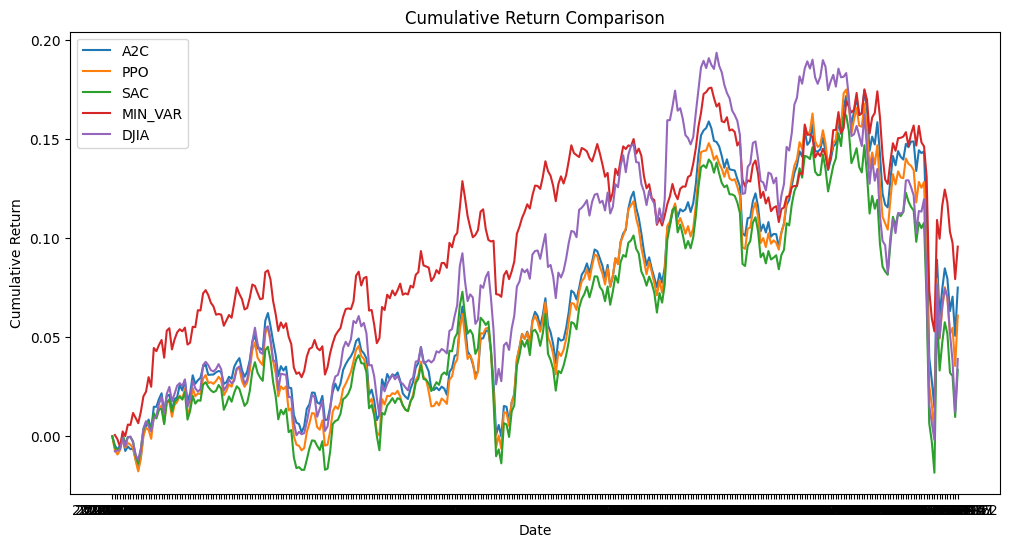

In [20]:
plt.figure(figsize=(12, 6))
for algo in algos:
    df_ret = results[algo]["df"]
    cump = (df_ret["daily_return"] + 1).cumprod() - 1
    plt.plot(df_ret["date"], cump, label=algo.upper())

# Min-var and DJIA
c_min = (min_var_df["account_value"].pct_change() + 1).cumprod() - 1
plt.plot(min_var_df["date"], c_min, label="MIN_VAR")
c_dji = (baseline_ret + 1).cumprod() - 1
plt.plot(baseline["date"], c_dji, label="DJIA")
plt.legend()
plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.savefig("results/cumulative_return_comparison.png")
plt.show()

## Review performance stats for each algorithm


In [21]:
perf_stats = pd.DataFrame({algo.upper(): results[algo]["stats"] for algo in algos})
display(perf_stats)

,A2C,PPO,SAC
Annual return,0.057343,0.046643,0.025766
Cumulative returns,0.075036,0.060941,0.033562
Annual volatility,0.142587,0.150161,0.153847
Sharpe ratio,0.463211,0.379127,0.242162
Calmar ratio,0.420820,0.316060,0.166002
Stability,0.715331,0.690218,0.626539
Max drawdown,-0.136266,-0.147578,-0.155215
Omega ratio,1.091920,1.074591,1.048578
Sortino ratio,0.661962,0.547517,0.349699
Skew,NaN,NaN,NaN
